In [ ]:
import random, numpy as np, torch, re
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Making sure to run in GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != "cuda":
    raise SystemExit("CUDA (GPU) not available.")


Using device: cuda


Loading the Split version of data from Hugging Face

In [ ]:
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset['train'].features['label'].names
num_labels = len(label_list)

train_data = list(zip(dataset['train']['text'], dataset['train']['label']))
val_data = list(zip(dataset['validation']['text'], dataset['validation']['label']))
test_data = list(zip(dataset['test']['text'], dataset['test']['label']))

Preprocessing and Visualizing the data

In [ ]:
url_pattern   = re.compile(r'https?://\S+')
mention_pattern = re.compile(r'@\w+')
hashtag_pattern = re.compile(r'#\w+')

def dataset_stats(data, name):
    texts = [t for t, _ in data]
    size = len(texts)
    urls = sum(bool(url_pattern.search(t)) for t in texts)
    mentions = sum(bool(mention_pattern.search(t)) for t in texts)
    hashtags = sum(bool(hashtag_pattern.search(t)) for t in texts)
    print(f"\n{name} Set:")
    print(f" Total samples: {size}")
    print(f" {urls} contain URLs")
    print(f" {mentions} contain @mentions")
    print(f" {hashtags} contain #hashtags")

dataset_stats(train_data, "Train")
dataset_stats(val_data, "Validation")
dataset_stats(test_data, "Test")


Train Set:
 Total samples: 16000
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags

Validation Set:
 Total samples: 2000
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags

Test Set:
 Total samples: 2000
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags


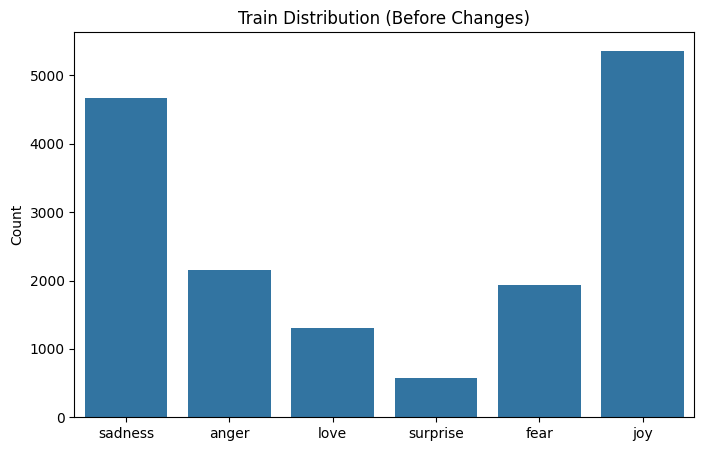

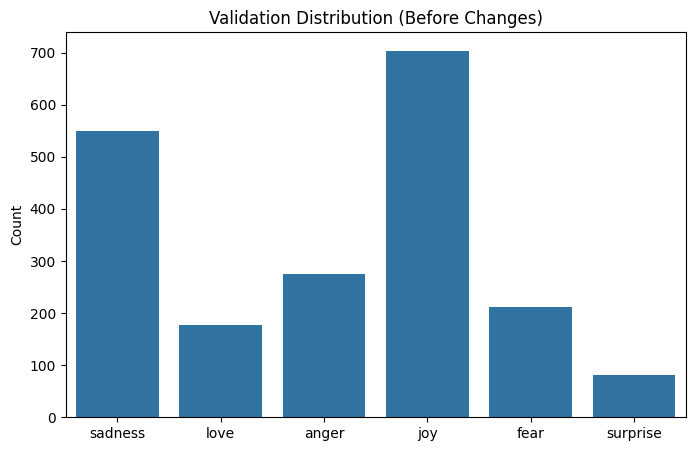

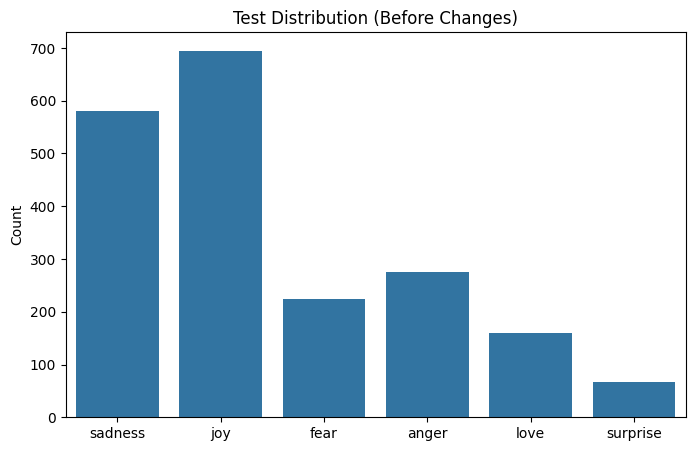

In [ ]:
def plot_class_distribution(data, title):
    counts = Counter(label for _, label in data)
    labels = [label_list[i] for i in counts.keys()]
    values = list(counts.values())
    plt.figure(figsize=(8,5))
    sns.barplot(x=labels, y=values)
    plt.title(title)
    plt.ylabel("Count")
    plt.show()


plot_class_distribution(train_data, "Train Distribution (Before Changes)")
plot_class_distribution(val_data, "Validation Distribution (Before Changes)")
plot_class_distribution(test_data, "Test Distribution (Before Changes)")

Tokenization

In [ ]:
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=90)

train_texts, train_labels = zip(*train_data)
val_texts, val_labels = zip(*val_data)
test_texts, test_labels = zip(*test_data)

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

train_labels = list(train_labels)
val_labels = list(val_labels)
test_labels = list(test_labels)

In [ ]:
# finding max lenghts
lengths = [len(tokenizer(t)["input_ids"]) for t in dataset['train']['text']]
import numpy as np

print("Max length:", np.max(lengths))



Max length: 87


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx])
        }

train_dataset = EmotionDataset(train_encodings, train_labels)
val_dataset = EmotionDataset(val_encodings, val_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)

Defining the Pooling Layer

In [ ]:

class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

Defining LMU

In [ ]:
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=87, num_layers=6):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.2),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.2),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size)
            ) for _ in range(num_layers)
        ])
        self.self_attention = nn.MultiheadAttention(hidden_size, num_heads=8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_output, _ = self.self_attention(x, x, x)
        return self.attention_norm(x + attn_output)

Combining all the components of the architecture 


In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden_states, attention_mask)
        return self.classifier(self.dropout(pooled))

model = EmotionClassifier(model_name, num_labels).to(device)

In [ ]:
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                           num_training_steps=len(train_loader) * 20)


Training and Evaluation

In [ ]:
def evaluate(loader):
    model.eval()
    total_loss, preds, labels = 0, [], []
    with torch.no_grad():
        for batch in loader:
            input_ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
            output = model(input_ids, mask)
            loss = criterion(output, targets)
            total_loss += loss.item()
            preds.extend(torch.argmax(output, dim=1).cpu().numpy())
            labels.extend(targets.cpu().numpy())
    return total_loss / len(loader), accuracy_score(labels, preds), preds, labels

In [ ]:
def train_model(epochs=100, patience=10):
    best_acc = 0.0
    best_epoch = 0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids, mask, targets = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, mask)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds_all.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        # Training and validation evaluation
        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc, _, _ = evaluate(val_loader)

        # Saving the values for early stopping and comparing them
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(total_loss / len(train_loader))
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}: Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), "Main_model_actual.pt")
        elif epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_acc:.4f}")
            break

    return history


history = train_model(epochs=100, patience=10)


Epoch 1: 100%|██████████| 500/500 [00:20<00:00, 24.95it/s]


Epoch 1: Train Acc 0.9216, Val Acc 0.9530


Epoch 2: 100%|██████████| 500/500 [00:19<00:00, 25.71it/s]


Epoch 2: Train Acc 0.9461, Val Acc 0.9480


Epoch 3: 100%|██████████| 500/500 [00:29<00:00, 16.75it/s]


Epoch 3: Train Acc 0.9516, Val Acc 0.9530


Epoch 4: 100%|██████████| 500/500 [00:50<00:00,  9.86it/s]


Epoch 4: Train Acc 0.9551, Val Acc 0.9505


Epoch 5: 100%|██████████| 500/500 [00:49<00:00, 10.05it/s]


Epoch 5: Train Acc 0.9601, Val Acc 0.9505


Epoch 6: 100%|██████████| 500/500 [00:55<00:00,  9.07it/s]


Epoch 6: Train Acc 0.9617, Val Acc 0.9525


Epoch 7: 100%|██████████| 500/500 [00:58<00:00,  8.61it/s]


Epoch 7: Train Acc 0.9634, Val Acc 0.9515


Epoch 8: 100%|██████████| 500/500 [00:31<00:00, 16.04it/s]


Epoch 8: Train Acc 0.9696, Val Acc 0.9530


Epoch 9: 100%|██████████| 500/500 [00:41<00:00, 12.06it/s]


Epoch 9: Train Acc 0.9704, Val Acc 0.9560


Epoch 10: 100%|██████████| 500/500 [00:40<00:00, 12.40it/s]


Epoch 10: Train Acc 0.9738, Val Acc 0.9565


Epoch 11: 100%|██████████| 500/500 [00:40<00:00, 12.33it/s]


Epoch 11: Train Acc 0.9764, Val Acc 0.9550


Epoch 12: 100%|██████████| 500/500 [00:46<00:00, 10.74it/s]


Epoch 12: Train Acc 0.9772, Val Acc 0.9540


Epoch 13: 100%|██████████| 500/500 [00:48<00:00, 10.34it/s]


Epoch 13: Train Acc 0.9792, Val Acc 0.9530


Epoch 14: 100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


Epoch 14: Train Acc 0.9800, Val Acc 0.9565


Epoch 15: 100%|██████████| 500/500 [00:18<00:00, 26.70it/s]


Epoch 15: Train Acc 0.9808, Val Acc 0.9540


Epoch 16: 100%|██████████| 500/500 [00:21<00:00, 23.64it/s]


Epoch 16: Train Acc 0.9820, Val Acc 0.9535


Epoch 17: 100%|██████████| 500/500 [00:19<00:00, 25.15it/s]


Epoch 17: Train Acc 0.9839, Val Acc 0.9540


Epoch 18: 100%|██████████| 500/500 [00:19<00:00, 26.18it/s]


Epoch 18: Train Acc 0.9842, Val Acc 0.9550


Epoch 19: 100%|██████████| 500/500 [00:18<00:00, 26.45it/s]


Epoch 19: Train Acc 0.9856, Val Acc 0.9550


Epoch 20: 100%|██████████| 500/500 [00:18<00:00, 27.66it/s]


Epoch 20: Train Acc 0.9849, Val Acc 0.9550
Early stopping at epoch 20. Best Val Acc: 0.9565


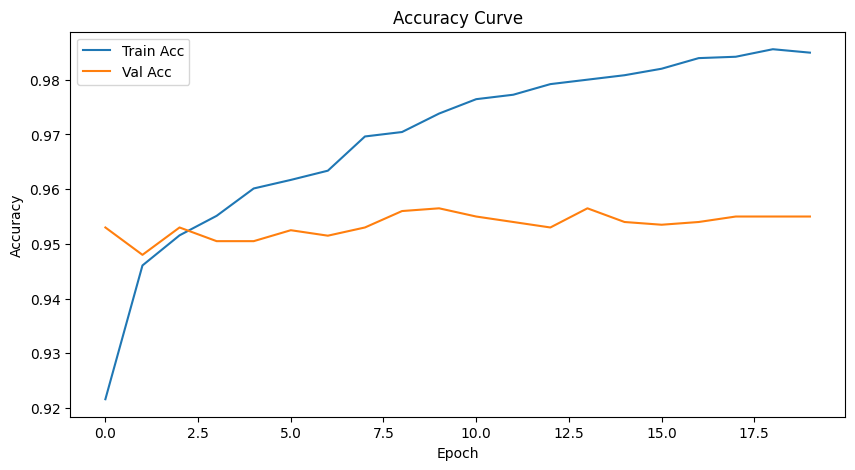

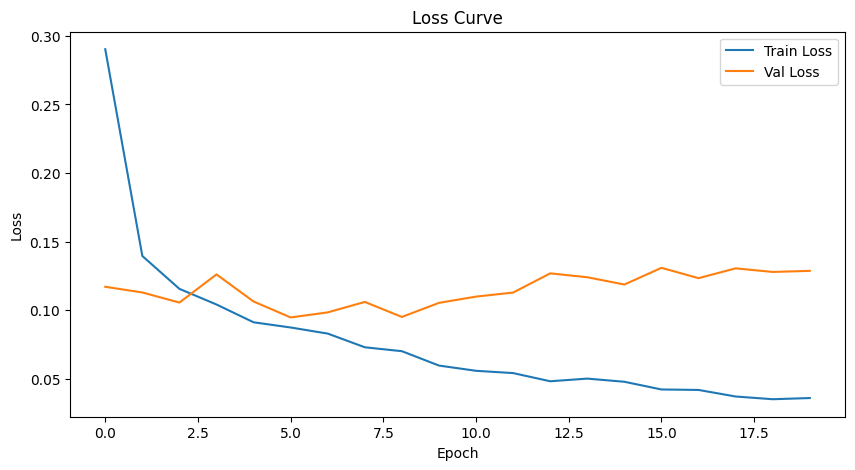

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

Testing the saved model


Test Classification Report:
               precision    recall  f1-score   support

     sadness       0.98      0.96      0.97       581
         joy       0.99      0.93      0.96       695
        love       0.78      0.96      0.86       159
       anger       0.93      0.96      0.95       275
        fear       0.94      0.94      0.94       224
    surprise       0.82      0.94      0.87        66

    accuracy                           0.95      2000
   macro avg       0.91      0.95      0.92      2000
weighted avg       0.95      0.95      0.95      2000



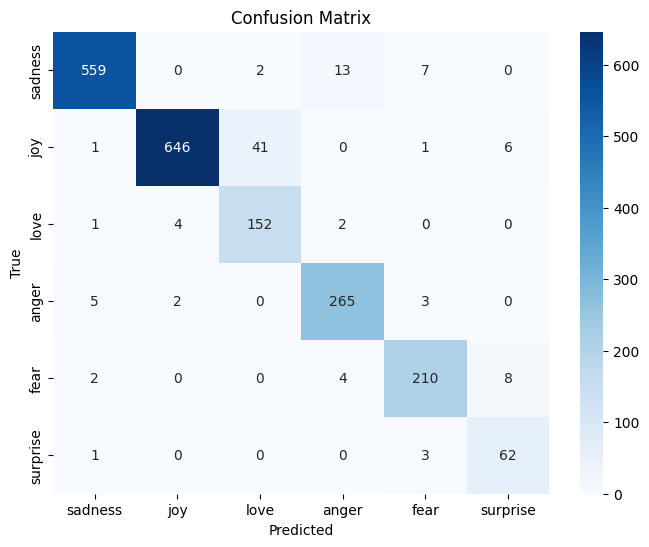

In [ ]:
model.load_state_dict(torch.load("Main_model_actual.pt"))
model.eval()
_, test_acc, preds, labels = evaluate(test_loader)
print("\nTest Classification Report:\n", classification_report(labels, preds, target_names=label_list))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
